## Preliminaries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import torch
import random
# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import os

/home/ilee300/workspace/nlp_ofa/transformers/src/transformers/models/bert/modeling_bert.py:874: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self.encoder != None, "the encoder cannot be None")
/home/ilee300/workspace/nlp_ofa/transformers/src/transformers/models/bert/modeling_bert.py:877: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self.encoder.config.num_hidden_layers >= max_encoder_num, "the max encoder number should not exceed defined hidden layer")


### Check available GPUs

In [2]:
!nvidia-smi

Thu Aug  5 17:14:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:1B:00.0 Off |                  N/A |
| 34%   55C    P2   157W / 250W |   1579MiB / 11019MiB |     51%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1C:00.0 Off |                  N/A |
| 24%   22C    P8    16W / 250W |     12MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

### Select device for training

In [3]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:3


### set source and destination folders

In [4]:
dirname = os.getcwd()

source_folder = os.path.join(dirname,'../data/imdb')
destination_folder =os.path.join(dirname,'../model/progressive_shrinking')

In [5]:
## check source and desitnation folder
print(source_folder)
print(destination_folder)

/home/ilee300/workspace/nlp_ofa/transformers/notebooks/../data/imdb
/home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/progressive_shrinking


## Prepare data 

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
# fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]
fields = [('text', text_field),('sentiment', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=True, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors


## Define Model class

In [8]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

## Helper functions

In [9]:

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

def save_accuracy_log(save_path, train_accuracy_list, valid_accuracy_list, global_steps_list):
    if save_path == None:
        return
    
    state_dict = {'train_accuracy_list': train_accuracy_list,
                  'valid_accuracy_list': valid_accuracy_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Accuracy log saved to ==> {save_path}')
    
def load_accuracy_log(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Accuracy log loaded from <== {load_path}')
    
    return state_dict['train_accuracy_list'], state_dict['valid_accuracy_list'], state_dict['global_steps_list']

### Training function

In [20]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf"),
         max_encoder_num = None,
         num_subnets = 2,
         sandwich=False):
    if sandwich:
        print("Sandwich training is on")
    print("a total of ", num_subnets, "subnets would be used for training")

    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    
    val_acc = 0.0
    train_acc = 0.0
    valid_accuracy_list = []
    train_accuracy_list = []
    val_y_pred = []
    val_y_true = []
    train_y_pred = []
    train_y_true = []
    
    
    if max_encoder_num is None:
        max_encoder_num = model.encoder.config.num_hidden_layers
        print("because max_encoder_num is none, it is set to", max_encoder_num) 
#     model.encoder.set_max_encoder_num(max_encoder_num)
#     print("training the model with encoder number of " , max_encoder_num)


    # training loop
    model.train()
    
    ##TODO
    change_subnet_every = len(train_iter) // num_subnets
   
    for epoch in range(num_epochs):
        
        ##Set the list of subnets to train
        subnet_depth_list = []
        subnet_counter = 0
        if sandwich:
            subnet_depth_list = [model.encoder.config.num_hidden_layers, max_encoder_num]
        subnet_depth_list.extend(random.choices(list(range(max_encoder_num, model.encoder.config.num_hidden_layers+1)), k=(num_subnets - len(subnet_depth_list))))
        random.shuffle(subnet_depth_list)
        print("subnet depths for training in epoch", epoch, " : ", subnet_depth_list)
        
        
        for (text,sentiment), _ in train_loader:
            if global_step % change_subnet_every == 0 and subnet_counter < num_subnets:
                print("at global step of ", global_step, " switching the subnet depth")
                model.encoder.set_max_encoder_num(subnet_depth_list[subnet_counter])
                print("training the model with encoder number of " , subnet_depth_list[subnet_counter])
                subnet_counter+=1
                
            
            text = text.type(torch.LongTensor)           
            text = text.to(device)
            sentiment = sentiment.type(torch.LongTensor)  
            sentiment = sentiment.to(device)
            output = model(text, sentiment)
            loss, output = output
            
            ##update the prediction and true list.
            train_y_pred.extend(torch.argmax(output, 1).tolist())
            train_y_true.extend(sentiment.tolist())
            train_acc +=accuracy_score(train_y_pred,train_y_true)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            
            # update running values
            running_loss += loss.item()
            global_step += 1
                    
            

            # evaluation step
            if global_step % eval_every == 0:
                ##run validation on the smallest and the largest
                
                model.eval()
                with torch.no_grad():

                    ## Change the number of encoder layers to max
                    model.encoder.set_max_encoder_num(model.encoder.config.num_hidden_layers)
                    
                    # Evaluation done on the largest subnet only while training.
                    # validation loop
                    for (text,sentiment), _ in valid_loader:
                        text = text.type(torch.LongTensor)           
                        text = text.to(device)
                        sentiment = sentiment.type(torch.LongTensor)  
                        sentiment = sentiment.to(device)
                        output = model(text, sentiment)
                        loss, output = output
                        
                        valid_running_loss += loss.item()
                        
                        ##update the prediction and true list.
                        val_y_pred.extend(torch.argmax(output, 1).tolist())
                        val_y_true.extend(sentiment.tolist())
                        val_acc += accuracy_score(val_y_pred,val_y_true)

                    # changethe number of encoder layers back 
                    model.encoder.set_max_encoder_num(subnet_depth_list[subnet_counter-1])

                    
                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                
                average_train_accuracy = train_acc / eval_every
                average_valid_accuracy = val_acc / eval_every
                train_accuracy_list.append(average_train_accuracy)
                valid_accuracy_list.append(average_valid_accuracy)
                

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                train_acc = 0.0
                val_acc = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' +str(max_encoder_num)+ 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + str(max_encoder_num)+ 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)


                
    save_metrics(file_path + '/' +str(max_encoder_num)+ 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    save_accuracy_log(file_path + '/' +str(max_encoder_num)+ 'acc_log.pt', train_accuracy_list, valid_accuracy_list, global_steps_list)

    print('Finished Training!')

### Evaluation Function

In [11]:
# Evaluation Function

def evaluate(model, test_loader,max_encoder_num=None ):
    y_pred = []
    y_true = []
    
    if max_encoder_num:
        model.encoder.set_max_encoder_num(max_encoder_num)
    else:
        max_encoder_num = model.encoder.config.num_hidden_layers
        model.encoder.set_max_encoder_num(model.encoder.config.num_hidden_layers)
    
    print("evaluating with max encoder number of ", max_encoder_num)
    model.eval()
    with torch.no_grad():
        for (text,sentiment), _ in test_loader:
                text = text.type(torch.LongTensor)           
                text = text.to(device)
                sentiment = sentiment.type(torch.LongTensor)  
                sentiment = sentiment.to(device)
                output = model(text, sentiment)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(sentiment.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['NEG', 'POS'])
    ax.yaxis.set_ticklabels(['NEG', 'POS'])
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_pred,y_true)

## Train 

### Train without sandwich
- Train each stage of shrinking for 1 epoch.
- evaluate the accuracy for all layers after each stage of training. Get the accuracy using the last model as well as the model with the highest largest supernet accuracy
- varying number of subnets

#### Train using 4 subnets per epoch.

In [12]:
# Initialize the model
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
# check if the encoder setting works
model.encoder.set_max_encoder_num(model.encoder.config.num_hidden_layers)


changing encoder number :  12  =>  12


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at



****starting with layer number of  12 ****
a total of  4 subnets would be used for training
subnet depths for training in epoch 0  :  [12, 12, 12, 12]
at global step of  0  switching the subnet depth
changing encoder number :  12  =>  12
training the model with encoder number of  12
at global step of  312  switching the subnet depth
changing encoder number :  12  =>  12
training the model with encoder number of  12
at global step of  624  switching the subnet depth
changing encoder number :  12  =>  12
training the model with encoder number of  12
changing encoder number :  12  =>  12
changing encoder number :  12  =>  12
Epoch [1/1], Step [625/1250], Train Loss: 0.3265, Valid Loss: 0.3873
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/progressive_shrinking/12model.pt
Model saved to ==> /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/progressive_shrinking/12metrics.pt
at global step of  936  switching the subnet depth
changing encod

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading the best model
Model loaded from <== /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/progressive_shrinking/12model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.5015    0.9993    0.6679     12500
           0     0.9053    0.0069    0.0137     12500

    accuracy                         0.5031     25000
   macro avg     0.7034    0.5031    0.3408     25000
weighted avg     0.7034    0.5031    0.3408     25000

accuracy when using  5  layers :  0.50308
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.5054    0.9988    0.6712     12500
           0     0.9497    0.0226    0.0442     12500

    accuracy                         0.5107     25000
   macro avg     0.7275    0.5107    0.3577     25000
weighted avg   

Classification Report:
              precision    recall  f1-score   support

           1     0.8882    0.7831    0.8324     12500
           0     0.8061    0.9014    0.8511     12500

    accuracy                         0.8423     25000
   macro avg     0.8471    0.8423    0.8417     25000
weighted avg     0.8471    0.8423    0.8417     25000

accuracy when using  10  layers :  0.84228
changing encoder number :  12  =>  11
evaluating with max encoder number of  11
Classification Report:
              precision    recall  f1-score   support

           1     0.8860    0.8096    0.8461     12500
           0     0.8247    0.8958    0.8588     12500

    accuracy                         0.8527     25000
   macro avg     0.8554    0.8527    0.8524     25000
weighted avg     0.8554    0.8527    0.8524     25000

accuracy when using  11  layers :  0.85272
changing encoder number :  12  =>  12
evaluating with max encoder number of  12
Classification Report:
              precision    reca

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading the best model
Model loaded from <== /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/progressive_shrinking/11model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.5012    0.9998    0.6677     12500
           0     0.9545    0.0050    0.0100     12500

    accuracy                         0.5024     25000
   macro avg     0.7279    0.5024    0.3389     25000
weighted avg     0.7279    0.5024    0.3389     25000

accuracy when using  5  layers :  0.5024
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.5173    0.9950    0.6807     12500
           0     0.9351    0.0714    0.1327     12500

    accuracy                         0.5332     25000
   macro avg     0.7262    0.5332    0.4067     25000
weighted avg    

Classification Report:
              precision    recall  f1-score   support

           1     0.9078    0.7927    0.8463     12500
           0     0.8160    0.9194    0.8647     12500

    accuracy                         0.8561     25000
   macro avg     0.8619    0.8561    0.8555     25000
weighted avg     0.8619    0.8561    0.8555     25000

accuracy when using  10  layers :  0.85608
changing encoder number :  12  =>  11
evaluating with max encoder number of  11
Classification Report:
              precision    recall  f1-score   support

           1     0.9102    0.7865    0.8438     12500
           0     0.8120    0.9224    0.8637     12500

    accuracy                         0.8544     25000
   macro avg     0.8611    0.8544    0.8538     25000
weighted avg     0.8611    0.8544    0.8538     25000

accuracy when using  11  layers :  0.85444
changing encoder number :  12  =>  12
evaluating with max encoder number of  12
Classification Report:
              precision    reca

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading the best model
Model loaded from <== /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/progressive_shrinking/10model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.5333    0.9898    0.6931     12500
           0     0.9288    0.1337    0.2337     12500

    accuracy                         0.5617     25000
   macro avg     0.7311    0.5617    0.4634     25000
weighted avg     0.7311    0.5617    0.4634     25000

accuracy when using  5  layers :  0.56172
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.5422    0.9877    0.7001     12500
           0     0.9309    0.1661    0.2819     12500

    accuracy                         0.5769     25000
   macro avg     0.7366    0.5769    0.4910     25000
weighted avg   

Classification Report:
              precision    recall  f1-score   support

           1     0.9344    0.7066    0.8047     12500
           0     0.7641    0.9504    0.8471     12500

    accuracy                         0.8285     25000
   macro avg     0.8493    0.8285    0.8259     25000
weighted avg     0.8493    0.8285    0.8259     25000

accuracy when using  11  layers :  0.82852
changing encoder number :  12  =>  12
evaluating with max encoder number of  12
Classification Report:
              precision    recall  f1-score   support

           1     0.9387    0.6882    0.7942     12500
           0     0.7539    0.9550    0.8426     12500

    accuracy                         0.8216     25000
   macro avg     0.8463    0.8216    0.8184     25000
weighted avg     0.8463    0.8216    0.8184     25000

accuracy when using  12  layers :  0.82164
results of the model trained using  9  layers 
5  ->  0.59724
6  ->  0.6198
7  ->  0.73728
8  ->  0.786
9  ->  0.85968
10  ->  0.84764

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading the best model
Model loaded from <== /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/progressive_shrinking/9model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.5386    0.9737    0.6936     12500
           0     0.8631    0.1660    0.2784     12500

    accuracy                         0.5698     25000
   macro avg     0.7009    0.5698    0.4860     25000
weighted avg     0.7009    0.5698    0.4860     25000

accuracy when using  5  layers :  0.56984
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.5399    0.9744    0.6948     12500
           0     0.8690    0.1698    0.2840     12500

    accuracy                         0.5721     25000
   macro avg     0.7045    0.5721    0.4894     25000
weighted avg    

Classification Report:
              precision    recall  f1-score   support

           1     0.8860    0.8424    0.8636     12500
           0     0.8498    0.8916    0.8702     12500

    accuracy                         0.8670     25000
   macro avg     0.8679    0.8670    0.8669     25000
weighted avg     0.8679    0.8670    0.8669     25000

accuracy when using  10  layers :  0.867
changing encoder number :  12  =>  11
evaluating with max encoder number of  11
Classification Report:
              precision    recall  f1-score   support

           1     0.8869    0.8461    0.8660     12500
           0     0.8528    0.8921    0.8720     12500

    accuracy                         0.8691     25000
   macro avg     0.8699    0.8691    0.8690     25000
weighted avg     0.8699    0.8691    0.8690     25000

accuracy when using  11  layers :  0.86908
changing encoder number :  12  =>  12
evaluating with max encoder number of  12
Classification Report:
              precision    recall

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading the best model
Model loaded from <== /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/progressive_shrinking/8model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.7401    0.8040    0.7707     12500
           0     0.7855    0.7177    0.7501     12500

    accuracy                         0.7608     25000
   macro avg     0.7628    0.7608    0.7604     25000
weighted avg     0.7628    0.7608    0.7604     25000

accuracy when using  5  layers :  0.76084
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.7503    0.8467    0.7956     12500
           0     0.8241    0.7182    0.7675     12500

    accuracy                         0.7824     25000
   macro avg     0.7872    0.7824    0.7815     25000
weighted avg    

Classification Report:
              precision    recall  f1-score   support

           1     0.8659    0.8762    0.8710     12500
           0     0.8747    0.8643    0.8695     12500

    accuracy                         0.8702     25000
   macro avg     0.8703    0.8702    0.8702     25000
weighted avg     0.8703    0.8702    0.8702     25000

accuracy when using  11  layers :  0.87024
changing encoder number :  12  =>  12
evaluating with max encoder number of  12
Classification Report:
              precision    recall  f1-score   support

           1     0.8611    0.8856    0.8732     12500
           0     0.8823    0.8572    0.8695     12500

    accuracy                         0.8714     25000
   macro avg     0.8717    0.8714    0.8714     25000
weighted avg     0.8717    0.8714    0.8714     25000

accuracy when using  12  layers :  0.8714
results of the model trained using  7  layers 
5  ->  0.75628
6  ->  0.7994
7  ->  0.813
8  ->  0.84248
9  ->  0.861
10  ->  0.87064
11

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading the best model
Model loaded from <== /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/progressive_shrinking/7model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.5825    0.9810    0.7310     12500
           0     0.9400    0.2968    0.4511     12500

    accuracy                         0.6389     25000
   macro avg     0.7612    0.6389    0.5911     25000
weighted avg     0.7612    0.6389    0.5911     25000

accuracy when using  5  layers :  0.63892
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.6107    0.9778    0.7518     12500
           0     0.9444    0.3766    0.5384     12500

    accuracy                         0.6772     25000
   macro avg     0.7775    0.6772    0.6451     25000
weighted avg    

Classification Report:
              precision    recall  f1-score   support

           1     0.8722    0.8667    0.8694     12500
           0     0.8675    0.8730    0.8702     12500

    accuracy                         0.8698     25000
   macro avg     0.8699    0.8698    0.8698     25000
weighted avg     0.8699    0.8698    0.8698     25000

accuracy when using  11  layers :  0.86984
changing encoder number :  12  =>  12
evaluating with max encoder number of  12
Classification Report:
              precision    recall  f1-score   support

           1     0.8724    0.8677    0.8700     12500
           0     0.8684    0.8731    0.8708     12500

    accuracy                         0.8704     25000
   macro avg     0.8704    0.8704    0.8704     25000
weighted avg     0.8704    0.8704    0.8704     25000

accuracy when using  12  layers :  0.8704
results of the model trained using  6  layers 
5  ->  0.71976
6  ->  0.7478
7  ->  0.7488
8  ->  0.82924
9  ->  0.85276
10  ->  0.87
11

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading the best model
Model loaded from <== /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/progressive_shrinking/6model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.8178    0.6670    0.7347     12500
           0     0.7188    0.8514    0.7795     12500

    accuracy                         0.7592     25000
   macro avg     0.7683    0.7592    0.7571     25000
weighted avg     0.7683    0.7592    0.7571     25000

accuracy when using  5  layers :  0.7592
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.7972    0.8109    0.8040     12500
           0     0.8076    0.7937    0.8006     12500

    accuracy                         0.8023     25000
   macro avg     0.8024    0.8023    0.8023     25000
weighted avg     

Classification Report:
              precision    recall  f1-score   support

           1     0.9161    0.7884    0.8475     12500
           0     0.8143    0.9278    0.8674     12500

    accuracy                         0.8581     25000
   macro avg     0.8652    0.8581    0.8574     25000
weighted avg     0.8652    0.8581    0.8574     25000

accuracy when using  11  layers :  0.85812
changing encoder number :  12  =>  12
evaluating with max encoder number of  12
Classification Report:
              precision    recall  f1-score   support

           1     0.9215    0.7742    0.8415     12500
           0     0.8053    0.9340    0.8649     12500

    accuracy                         0.8541     25000
   macro avg     0.8634    0.8541    0.8532     25000
weighted avg     0.8634    0.8541    0.8532     25000

accuracy when using  12  layers :  0.85412
results of the model trained using  5  layers 
5  ->  0.8324
6  ->  0.83328
7  ->  0.83432
8  ->  0.83292
9  ->  0.84004
10  ->  0.860

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

loading the best model
Model loaded from <== /home/ilee300/workspace/nlp_ofa/transformers/notebooks/../model/progressive_shrinking/5model.pt
changing encoder number :  12  =>  5
evaluating with max encoder number of  5
Classification Report:
              precision    recall  f1-score   support

           1     0.7970    0.6890    0.7391     12500
           0     0.7261    0.8245    0.7722     12500

    accuracy                         0.7568     25000
   macro avg     0.7616    0.7568    0.7556     25000
weighted avg     0.7616    0.7568    0.7556     25000

accuracy when using  5  layers :  0.75676
changing encoder number :  12  =>  6
evaluating with max encoder number of  6
Classification Report:
              precision    recall  f1-score   support

           1     0.7947    0.7886    0.7916     12500
           0     0.7902    0.7962    0.7932     12500

    accuracy                         0.7924     25000
   macro avg     0.7925    0.7924    0.7924     25000
weighted avg    

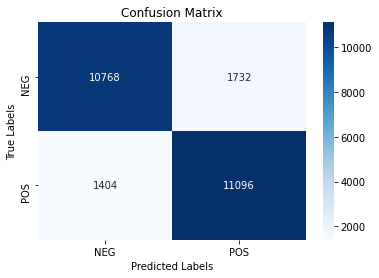

In [22]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
last_model_acc = np.zeros((8,8))
best_model_acc = np.zeros((8,8))
for i in range(12,4,-1):
    print("\n\n****starting with layer number of ",i,"****")
    train(model=model, optimizer=optimizer, max_encoder_num=i,num_epochs = 1,num_subnets=4)
    
    ## Evaluation using the last model
    for j in range(5,13):
        acc = evaluate(model, test_iter, max_encoder_num=j)
        last_model_acc[i-5][j-5] = acc
        print("accuracy when using ", j, " layers : ", acc)
    print("results of the model trained using ",i," layers ")
    for j in range(5,13):
        print(j, " -> ", last_model_acc[i-5][j-5])
    
    
    ## Evaluation using the best model (highest accuracy when using all 12 layers)
    best_model = BERT().to(device)
    print("loading the best model")
    load_checkpoint(destination_folder +"/"+ str(i)+ 'model.pt', best_model)
    for j in range(5,13):
        acc = evaluate(best_model, test_iter, max_encoder_num=j)
        best_model_acc[i-5][j-5] = acc
        print("accuracy when using ", j, " layers : ", acc)
    print("results of the model trained using ",i," layers ")
    for j in range(5,13):
        print(j, " -> ", best_model_acc[i-5][j-5])

In [23]:
# 4subnet_noSandwich_1epoch_last.npy
# 4subnet_noSandwich_1epoch_best.npy

with open('4subnet_noSandwich_1epoch_last.npy', 'wb') as f:
    np.save(f, last_model_acc)
with open('4subnet_noSandwich_1epoch_best.npy', 'wb') as f:    
    np.save(f, best_model_acc)
# with open('test.npy', 'rb') as f:
#     a = np.load(f)
#     b = np.load(f)

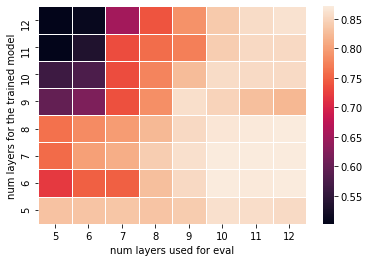

In [24]:
ax = sns.heatmap(last_model_acc,  linewidth=0.5,xticklabels=list(range(5,13)), yticklabels=list(range(5,13)))
ax.invert_yaxis()
ax.set_xlabel('num layers used for eval')
ax.set_ylabel('num layers for the trained model')
# ax.axis([5, 12,5,12])
plt.show()

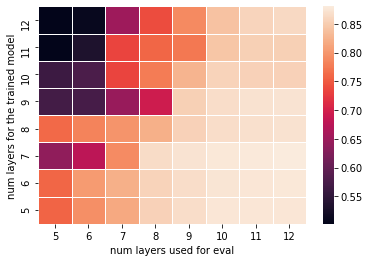

In [25]:
ax = sns.heatmap(best_model_acc,  linewidth=0.5,xticklabels=list(range(5,13)), yticklabels=list(range(5,13)))
ax.invert_yaxis()
ax.set_xlabel('num layers used for eval')
ax.set_ylabel('num layers for the trained model')
# ax.axis([5, 12,5,12])
plt.show()

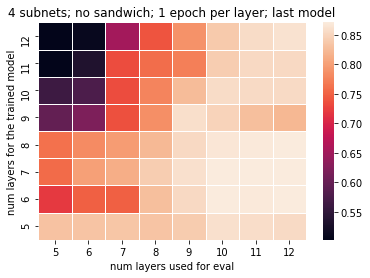

In [28]:
ax = sns.heatmap(last_model_acc,  linewidth=0.5,xticklabels=list(range(5,13)), yticklabels=list(range(5,13)))
ax.invert_yaxis()
ax.set_xlabel('num layers used for eval')
ax.set_ylabel('num layers for the trained model')
# ax.axis([5, 12,5,12])
plt.title("4 subnets; no sandwich; 1 epoch per layer; last model")
plt.savefig('4subnet_noSandwich_1epoch_last_heatmap.png')


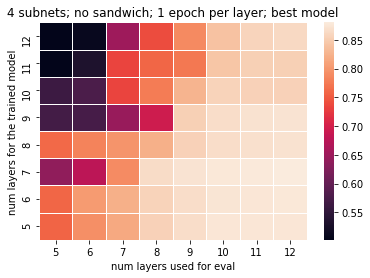

In [29]:
ax = sns.heatmap(best_model_acc,  linewidth=0.5,xticklabels=list(range(5,13)), yticklabels=list(range(5,13)))
ax.invert_yaxis()
ax.set_xlabel('num layers used for eval')
ax.set_ylabel('num layers for the trained model')
# ax.axis([5, 12,5,12])
plt.title("4 subnets; no sandwich; 1 epoch per layer; best model")
plt.savefig('4subnet_noSandwich_1epoch_best_heatmap.png')
